# R_t COVID-19 Canada

This notebook will serve as a playground for generating R_t rates for Canada. This heavily draws on the original notebook and research done by Kevin Systrom [here](https://github.com/k-sys/covid-19/blob/master/Realtime%20Rt%20mcmc.ipynb)

In [40]:
import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.dates import date2num, num2date

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [16]:
# These are the Brazillian notebook. They elect to use scipy to calculate posteriors + likelihoods
# TODO: Migrate to pymc3 eventually
from joblib import Parallel, delayed
from scipy import stats as sps
from scipy.stats import dirichlet
from scipy.interpolate import interp1d

from pygam import GammaGAM, PoissonGAM, s, l
from sklearn.utils import resample

In [4]:
# Download Canadian data file
def download_file(url, local_filename):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://raw.githubusercontent.com/ishaberry/Covid19Canada/master/cases.csv"
LINELIST_PATH = '../data/linelist.csv'
download_file(URL, LINELIST_PATH)


'../data/linelist.csv'

In [92]:
date_parser = lambda d: datetime.strptime(d, "%d-%m-%Y")

df = pd.read_csv('../data/linelist.csv', parse_dates=['date_report'], date_parser=date_parser)
#"case_id","provincial_case_id","age","sex","health_region","province","country","date_report","report_week","travel_yn","travel_history_country","locally_acquired","case_source","additional_info","additional_source","method_note"
# Filter by province because data is not complete for some provinces
df = df[~df['province'].isin(['Nunavut', 'Repatriated'])]
df

,case_id,provincial_case_id,age,sex,health_region,province,country,date_report,report_week,travel_yn,travel_history_country,locally_acquired,case_source,additional_info,additional_source,method_note
0,1,1,50-59,Male,Toronto,Ontario,Canada,2020-01-25,19-01-2020,1,China,NaN,(1) https://news.ontario.ca/mohltc/en/2020/01/...,NaN,NaN,0.0
1,2,2,50-59,Female,Toronto,Ontario,Canada,2020-01-27,26-01-2020,1,China,NaN,(1) https://news.ontario.ca/mohltc/en/2020/01/...,Travel and Close Contact,NaN,0.0
2,3,1,40-49,Male,Vancouver Coastal,BC,Canada,2020-01-28,26-01-2020,1,China,NaN,https://news.gov.bc.ca/releases/2020HLTH0015-0...,NaN,NaN,NaN
3,4,3,20-29,Female,Middlesex-London,Ontario,Canada,2020-01-31,26-01-2020,1,China,NaN,(1) https://news.ontario.ca/mohltc/en/2020/01/...,NaN,NaN,0.0
4,5,2,50-59,Female,Vancouver Coastal,BC,Canada,2020-02-04,02-02-2020,0,NaN,Close Contact,https://news.gov.bc.ca/releases/2020HLTH0023-0...,The individual had close contact with family v...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57775,57776,18181,Not Reported,Not Reported,York,Ontario,Canada,2020-05-02,26-04-2020,Not Reported,NaN,NaN,https://www.york.ca/wps/portal/yorkhome/health...,NaN,NaN,0.0
57776,57777,18182,Not Reported,Not Reported,York,Ontario,Canada,2020-05-02,26-04-2020,Not Reported,NaN,NaN,https://www.york.ca/wps/portal/yorkhome/health...,NaN,NaN,0.0
57777,57778,18183,Not Reported,Not Reported,York,Ontario,Canada,2020-05-02,26-04-2020,Not Reported,NaN,NaN,https://www.york.ca/wps/portal/yorkhome/health...,NaN,NaN,0.0
57778,57779,18184,Not Reported,Not Reported,York,Ontario,Canada,2020-05-02,26-04-2020,Not Reported,NaN,NaN,https://www.york.ca/wps/portal/yorkhome/health...,NaN,NaN,0.0


In [93]:
cases = df.groupby(['province', 'date_report']).count()[['case_id']].rename(columns={"case_id": 'confirmed_cases_by_day'})
province_df = cases['confirmed_cases_by_day']
province_df

province  date_report
Alberta   2020-03-05      1
          2020-03-06      1
          2020-03-08      2
          2020-03-09     10
          2020-03-11      5
                         ..
Yukon     2020-04-01      1
          2020-04-06      1
          2020-04-08      1
          2020-04-17      1
          2020-04-20      2
Name: confirmed_cases_by_day, Length: 471, dtype: int64

In [94]:
# Define constants used in this notebook
# Number of jobs: parallelism and the number of cores used.
N_JOBS = 4

R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

#OPTIMAL_SIGMA = 0.35 # through Kevin's Optimization
OPTIMAL_SIGMA = 0.01

In [95]:
# Functions copied from the Brazillian data set: https://github.com/loft-br/realtime_r0_brazil/blob/master/core.py

def run_full_model(cases, sigma=OPTIMAL_SIGMA):

    # initializing result dict
    result = {''}

    # smoothing series
    new, smoothed = smooth_new_cases(cases)

    # calculating posteriors
    posteriors, log_likelihood = calculate_posteriors(smoothed, sigma=sigma)

    # calculating HDI
    result = highest_density_interval(posteriors, p=.9)

    return result

def smooth_new_cases(new_cases):
    
    """
    Function to apply gaussian smoothing to cases
    Arguments
    ----------
    new_cases: time series of new cases
    Returns 
    ----------
    smoothed_cases: cases after gaussian smoothing
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    smoothed_cases = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed_cases.index[smoothed_cases.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed_cases.index.get_loc(last_zero) + 1
    smoothed_cases = smoothed_cases.iloc[idx_start:]
    original = new_cases.loc[smoothed_cases.index]
    
    return original, smoothed_cases


def calculate_posteriors(sr, sigma=0.15):

    """
    Function to calculate posteriors of Rt over time
    Arguments
    ----------
    sr: smoothed time series of new cases
    sigma: gaussian noise applied to prior so we can "forget" past observations
           works like exponential weighting
    Returns 
    ----------
    posteriors: posterior distributions
    log_likelihood: log likelihood given data
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood


def highest_density_interval(pmf, p=.9):

    """
    Function to calculate highest density interval 
    from posteriors of Rt over time
    Arguments
    ----------
    pmf: posterior distribution of Rt
    p: mass of high density interval
    Returns 
    ----------
    interval: expected value and density interval
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    most_likely = pmf.idxmax(axis=0)

    interval = pd.Series([most_likely, low, high], index=['ML',f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

    return interval



In [96]:

### running posteriors ###

with Parallel(n_jobs=N_JOBS) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], sigma=0.01) for grp in province_df.groupby(level='province'))

final_results = pd.concat(results)
final_results

ML  Low_90  High_90
province date_report                       
Alberta  2020-03-05   3.00    0.86     6.84
         2020-03-06   3.13    1.07     6.31
         2020-03-08   3.11    1.12     5.68
         2020-03-09   3.01    1.16     5.17
         2020-03-11   2.88    1.24     4.80
...                    ...     ...      ...
Yukon    2020-04-01   2.61    0.87     5.13
         2020-04-06   2.55    0.88     4.94
         2020-04-08   2.49    0.85     4.75
         2020-04-17   2.44    0.84     4.60
         2020-04-20   2.40    0.82     4.46

[471 rows x 3 columns]

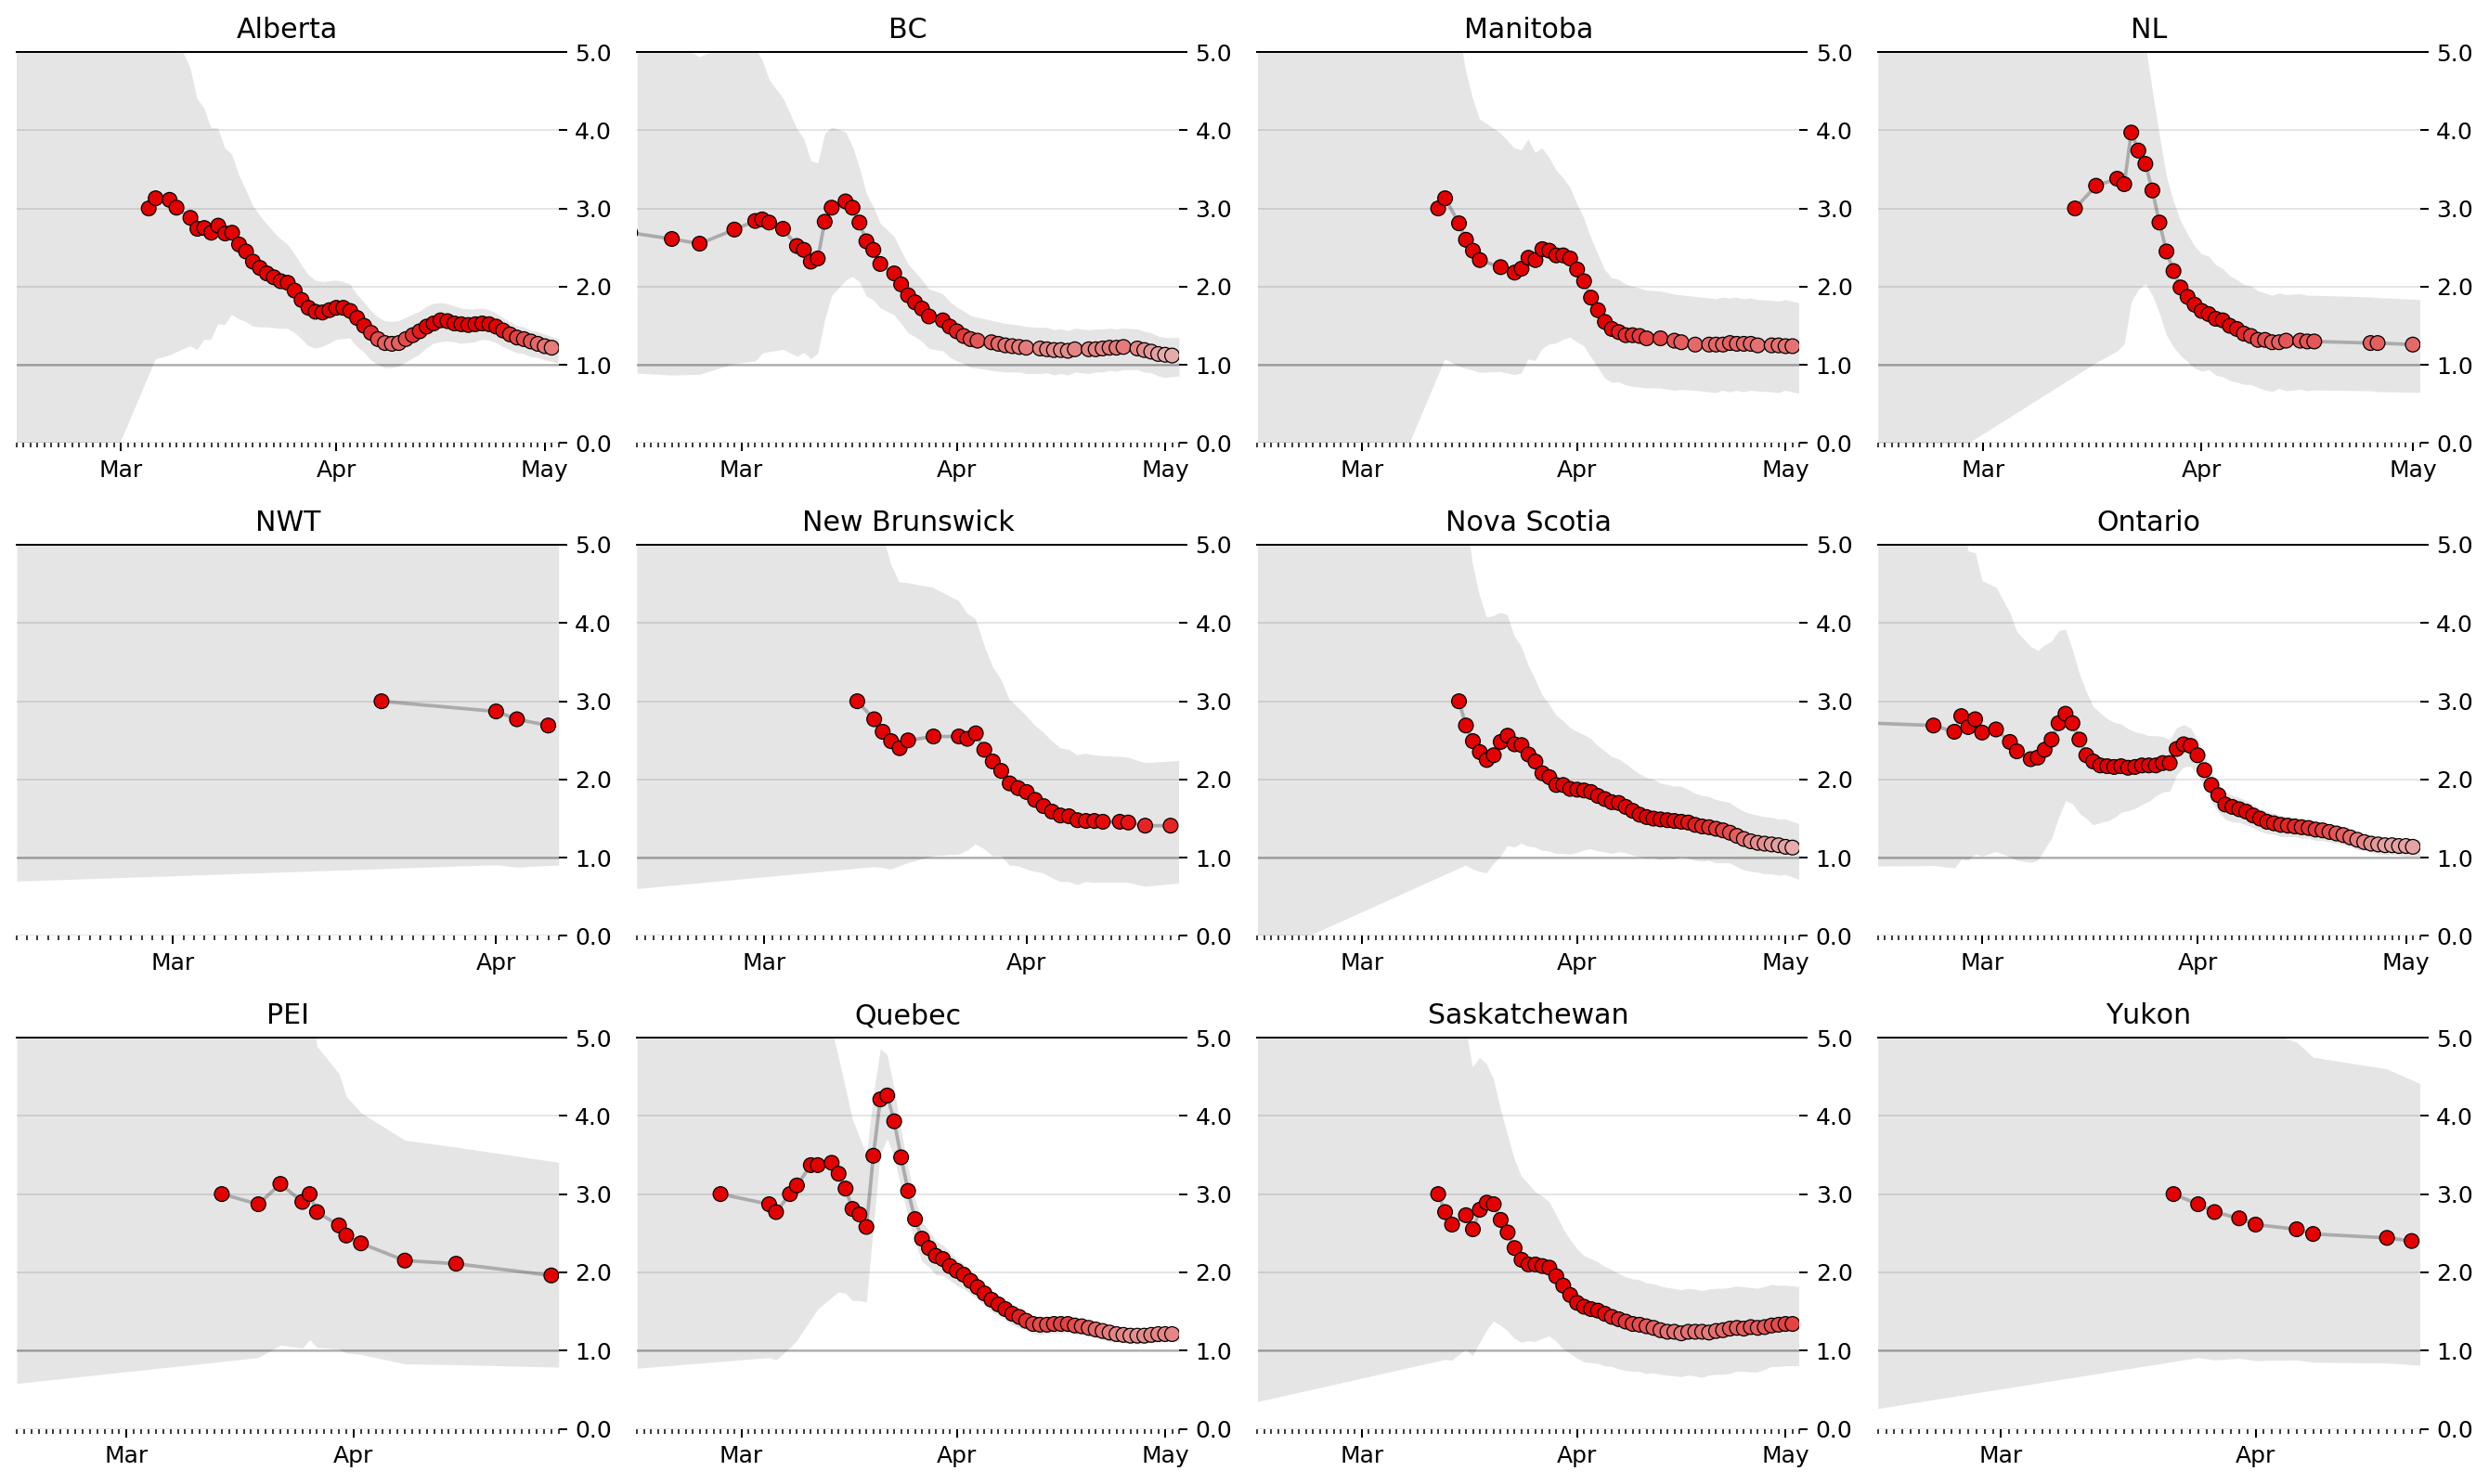

In [99]:

def plot_rt(result, ax, state_name, start_date=pd.Timestamp('2020-02-15')):
    
    """
    Function to plot Rt
    Arguments
    ----------
    result: expected value and HDI of posterior
    ax: matplotlib axes 
    state_name: state to be considered
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date_report')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=start_date,
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(start_date, result.index.get_level_values('date_report')[-1]+pd.Timedelta(days=1)) 


def plot_rt_by_province(final_results):

    # number of columns and rows for plotting
    N_COLS = 4
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    # opening figures
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=90)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('province')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_by_province(final_results)

In [122]:
# Transform to JSON
# Build a quick lookup map to standardize on formats
province_lookup_map = {
    'Alberta': 'AB',
    'BC': 'BC',
    'Manitoba': 'MB',
    'NL': 'NL',
    'NWT': 'NWT',
    'New Brunswick': 'NB',
    'Nova Scotia': 'NS',
    'Ontario': 'ON',
    'PEI': 'PEI',
    'Quebec': 'QB',
    'Saskatchewan': 'SK',
    'Yukon': 'YT'
}
d = final_results.to_dict(orient='index')
data = []
for key in d:
    # key is a 2-tuple of province, timestamp
    # val is a dict of ML, Low_90, High_90
    # data needs to be an array of literally combination of all keys + values into one object
    province, ds = key
    val = d[key]
    obj = {'province': province_lookup_map[province], 
           'date': int(ds.strftime('%s')), 
           'ML': val['ML'], 
           'Low_90': val['Low_90'],
           'High_90': val['High_90']
          }
    data.append(obj)

# Write this to JSON
import json
import datetime
today = datetime.date.today().strftime("%Y-%m-%d")
with open('../export/data_by_day/rt-ca-{}.json'.format(today), 'w') as fp:
    json.dump({"columns": ["province", "date", "ML", "Low_90", "High_90"], "data": data}, fp)